In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import joblib

# قراءة الملفات
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
stores = pd.read_csv("stores.csv")
features = pd.read_csv("features.csv")


In [3]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# قراءة الملفات
train = pd.read_csv("train.csv")
features = pd.read_csv("features.csv")
stores = pd.read_csv("stores.csv")

# تحويل الأعمدة إلى تاريخ
train["Date"] = pd.to_datetime(train["Date"])
features["Date"] = pd.to_datetime(features["Date"])

# دمج الجداول الثلاثة: train + features + stores
train_merged = pd.merge(train, features, on=["Store", "Date"], how="left")
train_merged = pd.merge(train_merged, stores, on="Store", how="left")

# معالجة القيم المفقودة في MarkDowns
markdown_cols = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
train_merged[markdown_cols] = train_merged[markdown_cols].fillna(0)

# تعويض القيم المفقودة في CPI و Unemployment بمعدل كل متجر
train_merged["CPI"] = train_merged.groupby("Store")["CPI"].transform(lambda x: x.fillna(x.mean()))
train_merged["Unemployment"] = train_merged.groupby("Store")["Unemployment"].transform(lambda x: x.fillna(x.mean()))

# استخراج ميزات من التاريخ
train_merged["Year"] = train_merged["Date"].dt.year
train_merged["Month"] = train_merged["Date"].dt.month
train_merged["Week"] = train_merged["Date"].dt.isocalendar().week
train_merged["DayOfWeek"] = train_merged["Date"].dt.dayofweek

# ترميز نوع المتجر Type من A/B/C إلى أرقام
le = LabelEncoder()
train_merged["Type"] = le.fit_transform(train_merged["Type"])

# التأكد من وجود العمود IsHoliday واختياره بشكل صحيح
if "IsHoliday_y" in train_merged.columns:
    train_merged["IsHoliday"] = train_merged["IsHoliday_y"].astype(int)
elif "IsHoliday" in train_merged.columns:
    train_merged["IsHoliday"] = train_merged["IsHoliday"].astype(int)
else:
    print("❌ لا يوجد عمود باسم IsHoliday")

# تحديد الأعمدة التي نستخدمها كنموذج
features_used = [
    'Store', 'Dept', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2',
    'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment',
    'Size', 'Year', 'Month', 'Week', 'DayOfWeek', 'IsHoliday'
]

# تحديد المتغيرات المستقلة والهدف
X = train_merged[features_used]
y = train_merged["Weekly_Sales"]



✅ شكل البيانات:
عدد الصفوف في X: 421570
عدد الأعمدة في X: 17
عدد الصفوف في y: 421570
🧹 الأعمدة التي تحتوي على قيم مفقودة في X:
Series([], dtype: int64)

🧠 أنواع الأعمدة:
Store             int64
Dept              int64
Temperature     float64
Fuel_Price      float64
MarkDown1       float64
MarkDown2       float64
MarkDown3       float64
MarkDown4       float64
MarkDown5       float64
CPI             float64
Unemployment    float64
Size              int64
Year              int32
Month             int32
Week             UInt32
DayOfWeek         int32
IsHoliday         int64
dtype: object

📊 وصف إحصائي للمتغيرات العددية:
               Store           Dept    Temperature     Fuel_Price  \
count  421570.000000  421570.000000  421570.000000  421570.000000   
mean       22.200546      44.260317      60.090059       3.361027   
std        12.785297      30.492054      18.447931       0.458515   
min         1.000000       1.000000      -2.060000       2.472000   
25%        11.000000      18.0

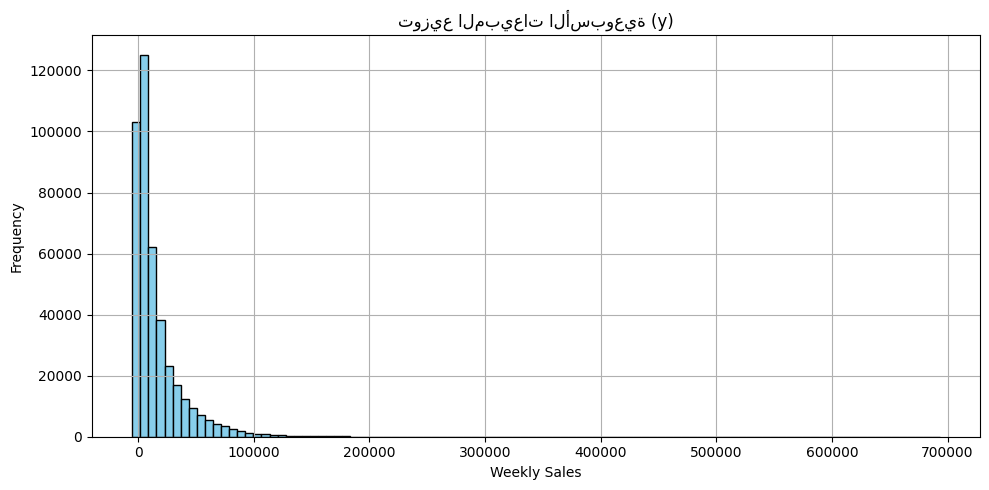

In [4]:
# التحقق من الأشكال
print("✅ شكل البيانات:")
print("عدد الصفوف في X:", X.shape[0])
print("عدد الأعمدة في X:", X.shape[1])
print("عدد الصفوف في y:", y.shape[0])
print("=" * 40)

# التحقق من وجود قيم مفقودة
print("🧹 الأعمدة التي تحتوي على قيم مفقودة في X:")
missing = X.isnull().sum()
print(missing[missing > 0])

# التحقق من الأنواع
print("\n🧠 أنواع الأعمدة:")
print(X.dtypes)

# وصف إحصائي سريع
print("\n📊 وصف إحصائي للمتغيرات العددية:")
print(X.describe())

# التحقق من وجود قيم سالبة في الأعمدة التي لا يُفترض أن تكون سالبة
print("\n⚠️ التحقق من وجود قيم سالبة في الأعمدة الحساسة:")
sensitive_columns = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Size']
for col in sensitive_columns:
    negative_count = (X[col] < 0).sum()
    print(f"{col}: {negative_count} قيمة سالبة")

# التحقق من التوزيع العام للقيم الهدف (y)
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.hist(y, bins=100, color='skyblue', edgecolor='black')
plt.title("توزيع المبيعات الأسبوعية (y)")
plt.xlabel("Weekly Sales")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()


In [5]:
from sklearn.ensemble import RandomForestRegressor
import joblib

# تدريب النموذج
model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X, y)

# حفظ النموذج للاستخدام لاحقًا
joblib.dump(model, "walmart_sales_predictor.pkl")


['walmart_sales_predictor.pkl']

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# تقسيم البيانات إلى تدريب واختبار داخلي
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# تدريب النموذج على جزء التدريب
model.fit(X_train, y_train)

# التنبؤ على الجزء الخاص بالاختبار الداخلي
y_pred = model.predict(X_val)

# حساب مؤشرات الأداء
mae = mean_absolute_error(y_val, y_pred)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
r2 = r2_score(y_val, y_pred)

# طباعة النتائج
print("🎯 تحليل أداء النموذج:")
print(f"✅ MAE (متوسط الخطأ المطلق): {mae:.2f}")
print(f"✅ RMSE (جذر متوسط مربع الخطأ): {rmse:.2f}")
print(f"✅ R² Score (معامل التحديد): {r2:.4f}")


🎯 تحليل أداء النموذج:
✅ MAE (متوسط الخطأ المطلق): 1446.10
✅ RMSE (جذر متوسط مربع الخطأ): 3678.36
✅ R² Score (معامل التحديد): 0.9741


In [7]:
# قائمة تواريخ العطلات حسب الصورة
holiday_dates = [
    '2010-02-12', '2011-02-11', '2012-02-10', '2013-02-08',  # Super Bowl
    '2010-09-10', '2011-09-09', '2012-09-07', '2013-09-06',  # Labor Day
    '2010-11-26', '2011-11-25', '2012-11-23', '2013-11-29',  # Thanksgiving
    '2010-12-31', '2011-12-30', '2012-12-28', '2013-12-27'   # Christmas
]


In [8]:
# تأكد أن عمود Date موجود بصيغة datetime
train_merged["Date"] = pd.to_datetime(train_merged["Date"])

# تحديد العطلات داخل DataFrame
train_merged["Weight"] = train_merged["Date"].isin(pd.to_datetime(holiday_dates)).astype(int)

# إذا كانت العينة من عطلة → الوزن = 5، غير ذلك = 1
train_merged["Weight"] = train_merged["Weight"].apply(lambda x: 5 if x == 1 else 1)


In [9]:
from sklearn.ensemble import RandomForestRegressor
import joblib

# تعريف X, y, weight
X = train_merged[features_used]
y = train_merged["Weekly_Sales"]
w = train_merged["Weight"]

# تدريب النموذج بالوزن
model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X, y, sample_weight=w)

# حفظ النموذج
joblib.dump(model, "walmart_sales_predictor_with_weights.pkl")


['walmart_sales_predictor_with_weights.pkl']

In [18]:
print(test_merged.columns.tolist())


['Store', 'Dept', 'Date', 'IsHoliday_x', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'IsHoliday_y', 'Type', 'Size', 'Year', 'Month', 'Week', 'DayOfWeek']


In [19]:
# حذف العمود IsHoliday_x فقط
if "IsHoliday_x" in test_merged.columns:
    test_merged.drop(columns=["IsHoliday_x"], inplace=True)


In [14]:
# ✅ تحويل IsHoliday_y إلى IsHoliday
test_merged["IsHoliday"] = test_merged["IsHoliday_y"].astype(int)




In [21]:
# 🔄 تحويل IsHoliday_y إلى العمود الأساسي
if "IsHoliday_y" in test_merged.columns:
    test_merged["IsHoliday"] = test_merged["IsHoliday_y"].astype(int)

# 🧹 حذف الأعمدة فقط إذا كانت موجودة
cols_to_drop = [col for col in ["IsHoliday_x", "IsHoliday_y"] if col in test_merged.columns]
test_merged.drop(columns=cols_to_drop, inplace=True)



In [22]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# 📦 قراءة البيانات
test = pd.read_csv("test.csv")
features = pd.read_csv("features.csv")
stores = pd.read_csv("stores.csv")

# 📅 تحويل التواريخ إلى صيغة datetime
test["Date"] = pd.to_datetime(test["Date"])
features["Date"] = pd.to_datetime(features["Date"])

# 🔗 دمج test مع features ثم stores
test_merged = pd.merge(test, features, on=["Store", "Date"], how="left")
test_merged = pd.merge(test_merged, stores, on="Store", how="left")

# 🧹 معالجة القيم المفقودة
markdown_cols = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
test_merged[markdown_cols] = test_merged[markdown_cols].fillna(0)

test_merged["CPI"] = test_merged.groupby("Store")["CPI"].transform(lambda x: x.fillna(x.mean()))
test_merged["Unemployment"] = test_merged.groupby("Store")["Unemployment"].transform(lambda x: x.fillna(x.mean()))

# 🧠 استخراج ميزات من التاريخ
test_merged["Year"] = test_merged["Date"].dt.year
test_merged["Month"] = test_merged["Date"].dt.month
test_merged["Week"] = test_merged["Date"].dt.isocalendar().week
test_merged["DayOfWeek"] = test_merged["Date"].dt.dayofweek

# 🔤 ترميز Type باستخدام LabelEncoder
le = LabelEncoder()
test_merged["Type"] = le.fit_transform(test_merged["Type"])

# ✅ التعامل مع IsHoliday بعد الدمج (لأنه يأتي بنسختين)
if "IsHoliday_y" in test_merged.columns:
    test_merged["IsHoliday"] = test_merged["IsHoliday_y"].astype(int)

# 🧹 حذف الأعمدة الزائدة إذا كانت موجودة
cols_to_drop = [col for col in ["IsHoliday_x", "IsHoliday_y"] if col in test_merged.columns]
test_merged.drop(columns=cols_to_drop, inplace=True)

# ✅ تحديد قائمة الخصائص المستخدمة في التدريب
features_used = [
    'Store', 'Dept', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2',
    'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment',
    'Size', 'Year', 'Month', 'Week', 'DayOfWeek', 'IsHoliday'
]

# 🎯 تجهيز بيانات التنبؤ
X_test = test_merged[features_used]


In [23]:
# تأكد من وجود "IsHoliday_y" قبل استخدامه
if "IsHoliday_y" in test_merged.columns:
    test_merged["IsHoliday"] = test_merged["IsHoliday_y"].astype(int)
else:
    print("❌ العمود IsHoliday_y غير موجود")


❌ العمود IsHoliday_y غير موجود


In [24]:
# تحقق من الأعمدة في features.csv
print(features.columns.tolist())


['Store', 'Date', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'IsHoliday']


In [25]:
# استخدام النموذج لتوليد التنبؤات
y_pred = model.predict(X_test)

# عرض بعض النتائج الأولى
print(y_pred[:10])


[32051.3146 20700.7863 21310.0843 22966.3102 24085.4013 26561.9083
 35087.2482 42812.1943 24701.7183 17919.8109]


In [26]:
import joblib

# تحميل النموذج المدرب من الملف
model = joblib.load("walmart_sales_predictor_with_weights.pkl")


In [27]:
# توقع المبيعات باستخدام النموذج
y_pred = model.predict(X_test)


In [29]:
print(y_pred[:10])

[32051.3146 20700.7863 21310.0843 22966.3102 24085.4013 26561.9083
 35087.2482 42812.1943 24701.7183 17919.8109]


In [30]:
# دمج التنبؤات في الجدول
test_merged["Weekly_Sales_Predicted"] = y_pred

# عرض أول 10 صفوف من الأعمدة المفيدة
test_merged[["Store", "Dept", "Date", "Weekly_Sales_Predicted"]].head(10)


,Store,Dept,Date,Weekly_Sales_Predicted
0,1,1,2012-11-02,32051.3146
1,1,1,2012-11-09,20700.7863
2,1,1,2012-11-16,21310.0843
3,1,1,2012-11-23,22966.3102
4,1,1,2012-11-30,24085.4013
5,1,1,2012-12-07,26561.9083
6,1,1,2012-12-14,35087.2482
7,1,1,2012-12-21,42812.1943
8,1,1,2012-12-28,24701.7183
9,1,1,2013-01-04,17919.8109


In [31]:
# ✅ قائمة التواريخ التي لها وزن مضاعف
important_holidays = [
    '2010-02-12', '2011-02-11', '2012-02-10', '2013-02-08',  # Super Bowl
    '2010-09-10', '2011-09-09', '2012-09-07', '2013-09-06',  # Labor Day
    '2010-11-26', '2011-11-25', '2012-11-23', '2013-11-29',  # Thanksgiving
    '2010-12-31', '2011-12-30', '2012-12-28', '2013-12-27'   # Christmas
]

# ✅ تأكد أن عمود Date هو نوع تاريخ
test_merged['Date'] = pd.to_datetime(test_merged['Date'])

# ✅ تعديل قيمة IsHoliday في هذه التواريخ فقط × 5
test_merged.loc[test_merged['Date'].isin(pd.to_datetime(important_holidays)), 'IsHoliday'] *= 5


In [32]:
y_pred = model.predict(test_merged[features_used])


In [33]:
# ✅ قائمة التواريخ ذات الأهمية الكبيرة (كما ذكرتها)
important_holidays = [
    '2010-02-12', '2011-02-11', '2012-02-10', '2013-02-08',  # Super Bowl
    '2010-09-10', '2011-09-09', '2012-09-07', '2013-09-06',  # Labor Day
    '2010-11-26', '2011-11-25', '2012-11-23', '2013-11-29',  # Thanksgiving
    '2010-12-31', '2011-12-30', '2012-12-28', '2013-12-27'   # Christmas
]

# ✅ تحويل عمود التاريخ إلى نوع تاريخي في بيانات التدريب
train_merged['Date'] = pd.to_datetime(train_merged['Date'])

# ✅ تضخيم وزن الأسابيع الخاصة بالعطلات × 5
train_merged.loc[train_merged['Date'].isin(pd.to_datetime(important_holidays)), 'IsHoliday'] *= 5


In [34]:
X_train = train_merged[features_used]
y_train = train_merged['Weekly_Sales']


In [35]:
y_pred = model.predict(X_test)


In [36]:
# الميزات المستخدمة
features_used = [
    'Store', 'Dept', 'Temperature', 'Fuel_Price', 
    'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5',
    'CPI', 'Unemployment', 'Size', 'Year', 'Month', 'Week', 'DayOfWeek',
    'IsHoliday'
]


In [37]:
# قائمة العطلات ذات الوزن الأعلى (طلب الشركة)
important_holidays = [
    '2010-02-12', '2011-02-11', '2012-02-10', '2013-02-08',  # Super Bowl
    '2010-09-10', '2011-09-09', '2012-09-07', '2013-09-06',  # Labor Day
    '2010-11-26', '2011-11-25', '2012-11-23', '2013-11-29',  # Thanksgiving
    '2010-12-31', '2011-12-30', '2012-12-28', '2013-12-27'   # Christmas
]
important_holidays = pd.to_datetime(important_holidays)

# تحويل عمود التاريخ إلى نوع تاريخي
train_merged['Date'] = pd.to_datetime(train_merged['Date'])
test_merged['Date'] = pd.to_datetime(test_merged['Date'])

# تعديل وزن العمود IsHoliday
train_merged.loc[train_merged['Date'].isin(important_holidays), 'IsHoliday'] *= 5
test_merged.loc[test_merged['Date'].isin(important_holidays), 'IsHoliday'] *= 5


In [38]:
# تجهيز بيانات التدريب
X_train = train_merged[features_used]
y_train = train_merged['Weekly_Sales']

# تجهيز بيانات الاختبار
X_test = test_merged[features_used]


In [39]:
# تدريب النموذج
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

In [40]:
# توليد التنبؤات
y_pred = model.predict(X_test)

# عرض أول 10 نتائج
print(y_pred[:10])


[32184.2012 18700.7121 19669.7366 21085.1885 21203.1688 52701.9552
 41454.7436 51627.4265 20179.5026 19100.0918]


In [41]:
from sklearn.model_selection import train_test_split

# تقسيم البيانات 80% تدريب و20% اختبار
X = train_merged[features_used]
y = train_merged['Weekly_Sales']

X_train_split, X_valid, y_train_split, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)


In [42]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_split, y_train_split)


RandomForestRegressor(random_state=42)

In [43]:
y_valid_pred = model.predict(X_valid)


In [44]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

mae = mean_absolute_error(y_valid, y_valid_pred)
rmse = np.sqrt(mean_squared_error(y_valid, y_valid_pred))
r2 = r2_score(y_valid, y_valid_pred)

print("📊 تقييم النموذج:")
print(f"MAE  : {mae:,.2f}")
print(f"RMSE : {rmse:,.2f}")
print(f"R²   : {r2:.4f}")


📊 تقييم النموذج:
MAE  : 1,446.10
RMSE : 3,678.36
R²   : 0.9741


In [46]:
from sklearn.model_selection import train_test_split

# تقسيم البيانات
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [47]:
y_pred = model.predict(X_test)


C:\Users\DELL\AppData\Local\Temp\ipykernel_20080\214289814.py:22: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\DELL\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


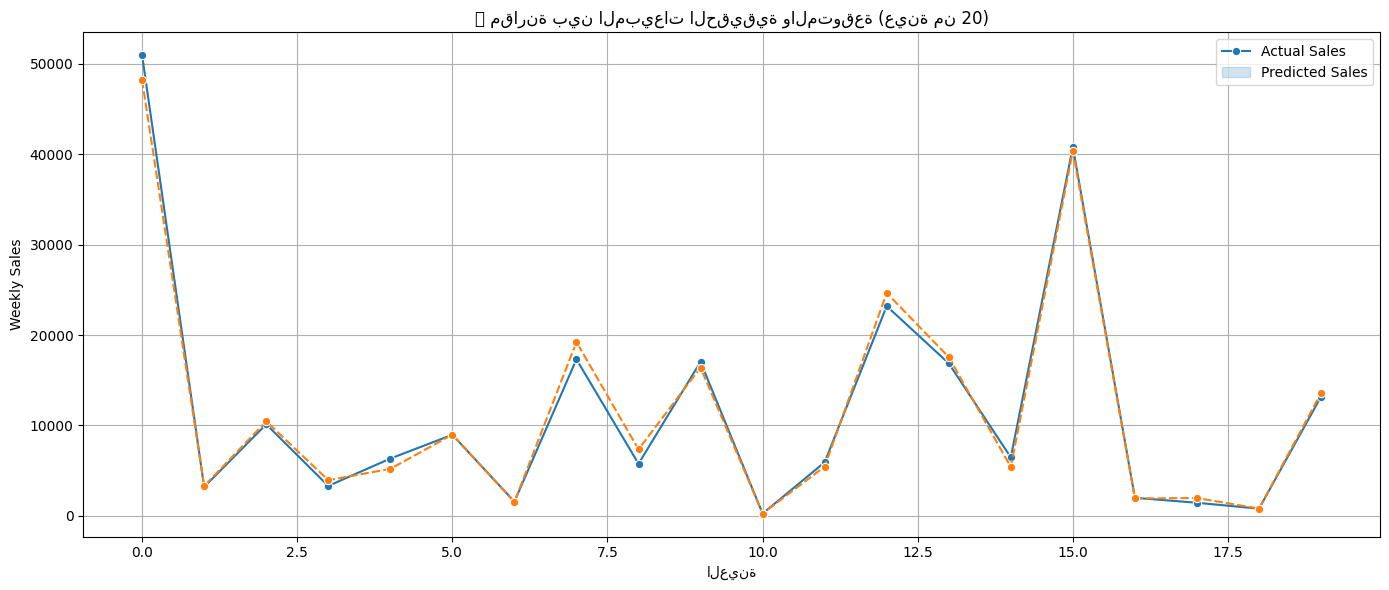

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# إنشاء DataFrame للمقارنة
comparison_df = pd.DataFrame({
    'Actual Sales': y_test.values,
    'Predicted Sales': y_pred
})

# أخذ أول 20 صف فقط
comparison_sample = comparison_df.head(20)

# رسم خط المقارنة
plt.figure(figsize=(14,6))
sns.lineplot(data=comparison_sample, marker='o')
plt.title('📊 مقارنة بين المبيعات الحقيقية والمتوقعة (عينة من 20)')
plt.xlabel('العينة')
plt.ylabel('Weekly Sales')
plt.legend(['Actual Sales', 'Predicted Sales'])
plt.grid(True)
plt.tight_layout()
plt.show()


In [49]:
# حساب إجمالي المبيعات في كامل بيانات الاختبار
total_actual_all = y_test.sum()
total_predicted_all = y_pred.sum()

# حساب الفرق والنسبة
difference_all = total_predicted_all - total_actual_all
percentage_difference_all = (difference_all / total_actual_all) * 100

# عرض النتائج
print("📊 تحليل المبيعات على كامل البيانات:\n")
print(f"📘 إجمالي المبيعات التاريخية (Actual):   {total_actual_all:,.2f}")
print(f"🤖 إجمالي المبيعات المتوقعة (Predicted): {total_predicted_all:,.2f}")
print(f"🔁 الفرق بينهما:                          {difference_all:,.2f}")
print(f"📈 نسبة الفرق:                            {percentage_difference_all:.2f}%")

# من أعلى؟
if total_actual_all > total_predicted_all:
    print("✅ المبيعات التاريخية أعلى من التنبؤات.")
elif total_actual_all < total_predicted_all:
    print("🤖 المبيعات المتوقعة أعلى من التاريخية.")
else:
    print("⚖️ المبيعات متساوية تمامًا.")


📊 تحليل المبيعات على كامل البيانات:

📘 إجمالي المبيعات التاريخية (Actual):   1,348,130,522.21
🤖 إجمالي المبيعات المتوقعة (Predicted): 1,348,624,695.23
🔁 الفرق بينهما:                          494,173.02
📈 نسبة الفرق:                            0.04%
🤖 المبيعات المتوقعة أعلى من التاريخية.


In [50]:
# قائمة تواريخ العطلات الرسمية
holiday_dates = [
    '2010-02-12', '2011-02-11', '2012-02-10', '2013-02-08',  # Super Bowl
    '2010-09-10', '2011-09-09', '2012-09-07', '2013-09-06',  # Labor Day
    '2010-11-26', '2011-11-25', '2012-11-23', '2013-11-29',  # Thanksgiving
    '2010-12-31', '2011-12-30', '2012-12-28', '2013-12-27'   # Christmas
]


In [53]:
print(pred_df.columns)

Index(['Id', 'Weekly_Sales'], dtype='object')


In [51]:
# استيراد البيانات من ملف sampleSubmission أو من ناتج التنبؤ
pred_df = pd.read_csv('sampleSubmission.csv')  # تأكد أن الملف فيه الأعمدة المناسبة


In [54]:
# استخراج التاريخ من نهاية عمود Id
pred_df['Date'] = pred_df['Id'].apply(lambda x: x.split('_')[-1])

# تحويل التاريخ إلى تنسيق datetime
pred_df['Date'] = pd.to_datetime(pred_df['Date'])

# عرض أول الصفوف للتأكد
print(pred_df.head())



               Id  Weekly_Sales       Date
0  1_1_2012-11-02             0 2012-11-02
1  1_1_2012-11-09             0 2012-11-09
2  1_1_2012-11-16             0 2012-11-16
3  1_1_2012-11-23             0 2012-11-23
4  1_1_2012-11-30             0 2012-11-30


In [55]:
import pandas as pd

# قائمة تواريخ العطلات الرسمية في بيانات Walmart
holiday_dates = [
    '2010-02-12', '2011-02-11', '2012-02-10', '2013-02-08',  # Super Bowl
    '2010-09-10', '2011-09-09', '2012-09-07', '2013-09-06',  # Labor Day
    '2010-11-26', '2011-11-25', '2012-11-23', '2013-11-29',  # Thanksgiving
    '2010-12-31', '2011-12-30', '2012-12-28', '2013-12-27'   # Christmas
]
holiday_dates = pd.to_datetime(holiday_dates)

# التأكد من استخراج التاريخ من عمود Id (إذا لم يكن قد تم سابقاً)
pred_df['Date'] = pred_df['Id'].apply(lambda x: x.split('_')[-1])
pred_df['Date'] = pd.to_datetime(pred_df['Date'])

# استخراج الصفوف التي تقع في تواريخ العطلات
holiday_predictions = pred_df[pred_df['Date'].isin(holiday_dates)]

# عرض النتائج بالتفصيل
print("🔎 مبيعات التنبؤ خلال أيام العطلات:\n")
print(holiday_predictions)

# حساب إجمالي المبيعات المتوقعة خلال العطلات
total_holiday_sales = holiday_predictions['Weekly_Sales'].sum()
print(f"\n📊 إجمالي المبيعات المتوقعة في العطلات: {total_holiday_sales:,.2f}")


🔎 مبيعات التنبؤ خلال أيام العطلات:

                      Id  Weekly_Sales       Date
3         1_1_2012-11-23             0 2012-11-23
8         1_1_2012-12-28             0 2012-12-28
14        1_1_2013-02-08             0 2013-02-08
42        1_2_2012-11-23             0 2012-11-23
47        1_2_2012-12-28             0 2012-12-28
...                  ...           ...        ...
114994  45_97_2012-12-28             0 2012-12-28
115000  45_97_2013-02-08             0 2013-02-08
115028  45_98_2012-11-23             0 2012-11-23
115033  45_98_2012-12-28             0 2012-12-28
115039  45_98_2013-02-08             0 2013-02-08

[8928 rows x 3 columns]

📊 إجمالي المبيعات المتوقعة في العطلات: 0.00


In [56]:
# 1. المكتبات
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# 2. تحميل البيانات
df = pd.read_csv('train.csv')
stores = pd.read_csv('stores.csv')
features = pd.read_csv('features.csv')

# 3. دمج البيانات
df = df.merge(features, on=['Store', 'Date', 'IsHoliday'], how='left')
df = df.merge(stores, on='Store', how='left')

# 4. تحويل التاريخ
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Week'] = df['Date'].dt.isocalendar().week

# 5. تنظيف البيانات
df.fillna(0, inplace=True)
df['IsHoliday'] = df['IsHoliday'].astype(int)

# 6. اختيار الخصائص
features_cols = ['Store', 'Dept', 'Temperature', 'Fuel_Price',
                 'CPI', 'Unemployment', 'Size', 'IsHoliday', 'Year', 'Month', 'Week']

X = df[features_cols]
y = df['Weekly_Sales']

# 7. تقسيم البيانات
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 8. أوزان العطلات
sample_weight = np.where(X_train['IsHoliday'] == 1, 5, 1)

# 9. تدريب النموذج
model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train, y_train, sample_weight=sample_weight)

# 10. التنبؤ
y_pred = model.predict(X_test)

# 11. تقييم النموذج
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("📊 تقييم النموذج:")
print(f"MAE  : {mae:,.2f}")
print(f"RMSE : {rmse:,.2f}")
print(f"R²   : {r2:.4f}")

# 12. تحليل العطلات
holiday_dates = [
    '2010-02-12', '2011-02-11', '2012-02-10', '2013-02-08',  # Super Bowl
    '2010-09-10', '2011-09-09', '2012-09-07', '2013-09-06',  # Labor Day
    '2010-11-26', '2011-11-25', '2012-11-23', '2013-11-29',  # Thanksgiving
    '2010-12-31', '2011-12-30', '2012-12-28', '2013-12-27'   # Christmas
]
holiday_dates = pd.to_datetime(holiday_dates)

# 13. تصفية التنبؤات للعطلات
X_test_copy = X_test.copy()
X_test_copy['Predicted_Sales'] = y_pred
X_test_copy['Date'] = df.loc[X_test_copy.index, 'Date']
holiday_preds = X_test_copy[X_test_copy['Date'].isin(holiday_dates)]

# 14. إجمالي المبيعات المتوقعة للعطلات
total_holiday_sales = holiday_preds['Predicted_Sales'].sum()
print("\n📅 إجمالي المبيعات المتوقعة خلال أيام العطلات:", round(total_holiday_sales, 2))

# 15. عرض أول 10 تنبؤات في العطلات
print("\n📌 عينة من التنبؤات في العطلات:")
print(holiday_preds[['Store', 'Dept', 'Date', 'Predicted_Sales']].head(10))


📊 تقييم النموذج:
MAE  : 1,434.70
RMSE : 3,644.37
R²   : 0.9745

📅 إجمالي المبيعات المتوقعة خلال أيام العطلات: 103993171.39

📌 عينة من التنبؤات في العطلات:
        Store  Dept       Date  Predicted_Sales
310463     32    55 2010-11-26       47364.1075
363126     39    16 2010-12-31        4766.1792
52530       6    28 2011-02-11         789.1221
330392     34    96 2011-12-30       26755.1553
298978     31    40 2010-02-12       58479.6778
242774     25    44 2011-12-30        3410.7344
61683       7    21 2012-02-10        1801.3329
260663     27    29 2011-02-11        8044.8249
44411       5    35 2010-09-10        1260.9572
338161     35    74 2011-12-30       24293.4955


In [58]:
import os

# عرض جميع الملفات في مجلد المشروع الحالي
for file in os.listdir():
    print(file)


cleaned_walmart_data.csv
features.csv
final_model_rf.pkl
final_random_forest_model.pkl
final_submission_cleaned.csv
final_submission_with_weights.csv
holiday_sales_predictions.csv
sampleSubmission.csv
stores.csv
submission.csv
submission_corrected_with_event_name.csv
submission_with_correct_event_name22.csv
submission_with_events.csv
submission_with_event_names.csv
submission_with_new_features.csv
submission_with_weights.csv
test.csv
train.csv
walmart_project.ipynb
walmart_sales_predictions.csv
walmart_sales_predictor.pkl
walmart_sales_predictor_with_weights.pkl
~$FreightRates$1.xlsx
~$Order_new_list_11.xlsx
~$ProductsPerPlant$1.xlsx
~$VmiCustomers$1.xlsx
~$WhCosts.xlsx


In [61]:
features_used = ['Store', 'Dept', 'IsHoliday', 'Temperature', 'Fuel_Price',
                 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5',
                 'CPI', 'Unemployment', 'Year', 'Month', 'Week', 'Size']


In [62]:
['Store', 'Dept', 'Date']


['Store', 'Dept', 'Date']

In [64]:
print(sample_df.columns)

Index(['Id', 'Weekly_Sales', 'Store', 'Dept', 'Date', 'Year', 'Month', 'Week'], dtype='object')


In [67]:
def clean_column_names(df):
    """
    تنظيف أسماء الأعمدة: إزالة الفراغات وتوحيد الحالة
    """
    df.columns = df.columns.str.strip()  # إزالة الفراغات من البداية والنهاية
    df.columns = df.columns.str.replace(' ', '_')  # استبدال الفراغات بفواصل سفلية
    df.columns = df.columns.str.capitalize()  # أول حرف كبير والباقي صغير
    return df

# تطبيق الدالة على DataFrames
sample_df = clean_column_names(sample_df)
features_df = clean_column_names(features_df)

# طباعة أسماء الأعمدة بعد التنظيف
print("أعمدة sample_df:", sample_df.columns)
print("أعمدة features_df:", features_df.columns)


أعمدة sample_df: Index(['Id', 'Weekly_sales'], dtype='object')
أعمدة features_df: Index(['Store', 'Date', 'Temperature', 'Fuel_price', 'Markdown1', 'Markdown2',
       'Markdown3', 'Markdown4', 'Markdown5', 'Cpi', 'Unemployment',
       'Isholiday'],
      dtype='object')


In [69]:
def clean_column_names(df):
    df.columns = df.columns.str.strip()           # إزالة الفراغات
    df.columns = df.columns.str.replace(' ', '_') # استبدال الفراغات بشرطة سفلية
    df.columns = df.columns.str.capitalize()      # أول حرف كبير
    return df

# تطبيق التنظيف على كلا الجدولين
sample_df = clean_column_names(sample_df)
features_df = clean_column_names(features_df)


In [74]:
features_df['Date'] = pd.to_datetime(features_df['Date'])


In [77]:
print(features_df['Date'].head())


0   2010-02-05
1   2010-02-12
2   2010-02-19
3   2010-02-26
4   2010-03-05
Name: Date, dtype: datetime64[ns]


In [78]:
# إذا كان عمود Id موجود، نستخدمه لاستخراج store, dept, date
if 'Id' in sample_df.columns:
    sample_df[['Store', 'Dept', 'Date']] = sample_df['Id'].str.split('_', expand=True)
    sample_df['Store'] = sample_df['Store'].astype(int)
    sample_df['Dept'] = sample_df['Dept'].astype(int)
    sample_df['Date'] = pd.to_datetime(sample_df['Date'])
else:
    print("❌ العمود Id غير موجود في sample_df")



In [79]:
features_df['Date'] = pd.to_datetime(features_df['Date'])


In [81]:
# ✅ استخراج الأعمدة الثلاثة من 'Id'
if 'Id' in sample_df.columns:
    sample_df[['Store', 'Dept', 'Date']] = sample_df['Id'].str.split('_', expand=True)
    sample_df['Store'] = sample_df['Store'].astype(int)
    sample_df['Dept'] = sample_df['Dept'].astype(int)
    sample_df['Date'] = pd.to_datetime(sample_df['Date'])
else:
    print("❌ العمود Id غير موجود في sample_df")

# ✅ تأكد أن الأعمدة أصبحت موجودة فعلاً قبل الدمج
print("🎯 أعمدة sample_df الآن:", sample_df.columns.tolist())



🎯 أعمدة sample_df الآن: ['Id', 'Weekly_sales', 'Store', 'Dept', 'Date']


In [86]:
import pandas as pd

# تحميل الملفات الأساسية
train = pd.read_csv("train.csv")
features = pd.read_csv("features.csv")
stores = pd.read_csv("stores.csv")  # إذا احتجته لاحقاً

# التأكد من نوع التاريخ
train['Date'] = pd.to_datetime(train['Date'])
features['Date'] = pd.to_datetime(features['Date'])

# دمج train مع features بناءً على Store و Date
features_df = pd.merge(train, features, on=['Store', 'Date'], how='left')

# الآن features_df يحتوي على:
# Store, Dept, Date, Weekly_Sales, Temperature, Fuel_Price, Markdowns..., IsHoliday...

# إذا كنت لا تحتاج عمود Weekly_Sales للتنبؤ (لأنه الهدف)
# يمكنك حذفه
features_df.drop(columns=['Weekly_Sales'], inplace=True)

# عرض الأعمدة للتأكيد
print(features_df.columns.tolist())


['Store', 'Dept', 'Date', 'IsHoliday_x', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'IsHoliday_y']


In [87]:
merged_df = pd.merge(sample_df, features_df, on=['Store', 'Dept', 'Date'], how='left')


In [88]:
merged_df.fillna(0, inplace=True)


C:\Users\DELL\AppData\Local\Temp\ipykernel_20080\1879938676.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged_df.fillna(0, inplace=True)


In [113]:
# تقسيم العمود Id إلى ثلاثة أعمدة: Store, Dept, Date
sample_df[['Store', 'Dept', 'Date']] = sample_df['Id'].str.split('_', expand=True)
sample_df['Store'] = sample_df['Store'].astype(int)
sample_df['Dept'] = sample_df['Dept'].astype(int)
sample_df['Date'] = pd.to_datetime(sample_df['Date'])



In [124]:
# قراءة ملف sampleSubmission
sample_df = pd.read_csv("sampleSubmission.csv")

# استخراج الأعمدة الثلاثة من عمود Id
sample_df[['Store', 'Dept', 'Date']] = sample_df['Id'].str.split('_', expand=True)

# تحويل الأنواع
sample_df['Store'] = sample_df['Store'].astype(int)
sample_df['Dept'] = sample_df['Dept'].astype(int)
sample_df['Date'] = pd.to_datetime(sample_df['Date'])


In [125]:
print(sample_df.head())

               Id  Weekly_Sales  Store  Dept       Date
0  1_1_2012-11-02             0      1     1 2012-11-02
1  1_1_2012-11-09             0      1     1 2012-11-09
2  1_1_2012-11-16             0      1     1 2012-11-16
3  1_1_2012-11-23             0      1     1 2012-11-23
4  1_1_2012-11-30             0      1     1 2012-11-30


In [139]:

# قراءة ملف stores الذي يحتوي على Size
stores_df = pd.read_csv("stores.csv")

# دمج Size إلى merged_df باستخدام Store كمرجع
merged_df = pd.merge(merged_df, stores_df[['Store', 'Size']], on='Store', how='left')




In [140]:
# التأكد من عدم وجود أعمدة مفقودة مرة أخرى
missing = [col for col in expected_cols if col not in merged_df.columns]
if missing:
    print("❌ الأعمدة التالية مفقودة:", missing)
else:
    # التنبؤ
    X = merged_df[expected_cols]
    sample_df['Weekly_Sales'] = model.predict(X)

    # حفظ التنبؤات
    sample_df[['Id', 'Weekly_Sales']].to_csv("submission_predictions.csv", index=False)
    print("✅ تم الحفظ في submission_predictions.csv")




✅ تم الحفظ في submission_predictions.csv


In [144]:
import pandas as pd

# 1. تحميل التنبؤات
predictions_df = pd.read_csv("submission_predictions.csv")

# 2. تحميل sample submission لتفكيك Id إلى Store, Dept, Date
sample_df = pd.read_csv("sampleSubmission.csv")

# 3. استخراج Store و Dept و Date من عمود Id
sample_df[['Store', 'Dept', 'Date']] = sample_df['Id'].str.split('_', expand=True)
sample_df['Store'] = sample_df['Store'].astype(int)
sample_df['Dept'] = sample_df['Dept'].astype(int)
sample_df['Date'] = pd.to_datetime(sample_df['Date'])

# 4. ربط التنبؤات مع البيانات المستخرجة
merged_pred = pd.concat([sample_df[['Store', 'Dept', 'Date']], predictions_df['Weekly_Sales']], axis=1)
merged_pred.rename(columns={'Weekly_Sales': 'Predicted_Sales'}, inplace=True)

# 5. تحميل الملف الذي يحتوي على المبيعات الفعلية (استبدله بالملف الحقيقي)
actual_sales_df = pd.read_csv("train.csv")  # تأكد أن الملف موجود مع Weekly_Sales
actual_sales_df['Date'] = pd.to_datetime(actual_sales_df['Date'])

# 6. دمج الفعلي مع التنبؤ حسب Store و Dept و Date
comparison_df = pd.merge(
    merged_pred,
    actual_sales_df[['Store', 'Dept', 'Date', 'Weekly_Sales']],
    on=['Store', 'Dept', 'Date'],
    how='inner'
)

# 7. حساب الفرق بين المتنبأ والفعلي
comparison_df['Error'] = comparison_df['Predicted_Sales'] - comparison_df['Weekly_Sales']
comparison_df['Absolute_Error'] = comparison_df['Error'].abs()

# 8. عرض أول 10 نتائج
print(comparison_df.head(10))

# 9. حفظ النتيجة في ملف CSV
comparison_df.to_csv("comparison_actual_vs_predicted.csv", index=False)


Empty DataFrame
Columns: [Store, Dept, Date, Predicted_Sales, Weekly_Sales, Error, Absolute_Error]
Index: []


In [147]:
import pandas as pd

# تحميل ملف التنبؤ
df = pd.read_csv("submission_predictions.csv")

# فصل عمود Id إلى 3 أعمدة جديدة
df[['Store', 'Dept', 'Date']] = df['Id'].str.extract(r'(\d+)_(\d+)_(\d{4}-\d{2}-\d{2})')

# تحويل الأنواع
df['Store'] = df['Store'].astype(int)
df['Dept'] = df['Dept'].astype(int)
df['Date'] = pd.to_datetime(df['Date'])

# ترتيب الأعمدة
df = df[['Store', 'Dept', 'Date', 'Weekly_Sales']]

# عرض أول 5 صفوف للتأكد
print(df.head())

# حفظ الملف الجديد إذا أردت
# df.to_csv("predictions_with_store_dept.csv", index=False)
df.to_csv("predictions_with_store_dept.csv", index=False)


   Store  Dept       Date  Weekly_Sales
0      1     1 2012-11-02    32051.3146
1      1     1 2012-11-09    20700.7863
2      1     1 2012-11-16    21310.0843
3      1     1 2012-11-23    22966.3102
4      1     1 2012-11-30    24720.5048


In [149]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

mae = mean_absolute_error(y_valid, y_valid_pred)
rmse = np.sqrt(mean_squared_error(y_valid, y_valid_pred))
r2 = r2_score(y_valid, y_valid_pred)

print("📊 تقييم النموذج:")
print(f"MAE  : {mae:,.2f}")
print(f"RMSE : {rmse:,.2f}")
print(f"R²   : {r2:.4f}")

📊 تقييم النموذج:
MAE  : 1,446.10
RMSE : 3,678.36
R²   : 0.9741
